Здесь производится проверка интегратора на простых фигурах.

Проверяется правильность подсчёта площади и коэффициентов $C_x, C_y, C_z$. Простые фигуры используются для того, чтобы можно было вручную посчитать значения этих величин и потом сравнить с тем, что выдаёт программа

In [1]:
# библиотеки общего назначения
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


# для работы с файлами
import glob



# для построения суррогатных моделей
import sklearn.metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator

# LS - The Least square model
from smt.surrogate_models import LS, KRG

# RBF из SMT не подключается (из другой библиотеки - всё норм) [проблема именно на домашнем компьютере]
# from smt.surrogate_models import RBF

from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

# для сохранения и загрузки суррогатных моделей
import joblib

import my3D_surface_integrator as sint

# Чтение данных

In [2]:
regimes = (pd.read_csv("./data/regimes.csv")).drop(['Num'],axis=1)
M_is = pd.DataFrame(columns=np.arange(regimes.shape[0]))
Cp = pd.DataFrame(columns=np.arange(regimes.shape[0]))

files = glob.glob("data/*_*_*.csv")
files.sort()
for i,path in enumerate(files):
    M_is[i] = pd.read_csv(path)['M_is']
    Cp[i] = pd.read_csv(path)['Cp']
    
XYZ_coords = pd.read_csv(files[0]).drop(['Cp', 'M_is'], axis=1)

coefCxyz = pd.DataFrame(columns=['Cx', 'Cy', 'Cz'], data=np.zeros((regimes.shape[0],3)))

files = glob.glob("results/*_*_*")
files.sort()
for i,path in enumerate(files):
    f = open(path, mode='r')

    l = f.readlines()[22]
    sep_words = l.split()

    coefCxyz.iloc[i][0] = float(sep_words[-3])
    coefCxyz.iloc[i][1] = float(sep_words[-2])
    coefCxyz.iloc[i][2] = float(sep_words[-1])    

    f.close()

In [3]:
M_is

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.632708,0.571669,0.390198,0.427720,0.473098,0.480165,0.413340,0.458278,0.394294,0.485033,...,0.427569,0.530273,0.612114,0.397551,0.542801,0.420202,0.482756,0.601575,0.429612,0.576284
1,0.624054,0.562945,0.389021,0.423578,0.468002,0.473987,0.411813,0.453089,0.393816,0.478279,...,0.425911,0.522455,0.602968,0.395439,0.535451,0.416633,0.476312,0.592400,0.426305,0.568566
2,0.617871,0.556658,0.388920,0.420878,0.464434,0.469505,0.411405,0.449446,0.394388,0.473356,...,0.425394,0.516773,0.596469,0.394538,0.530111,0.414456,0.471624,0.585883,0.424350,0.562979
3,0.609374,0.548063,0.389335,0.417898,0.460239,0.463948,0.411384,0.445164,0.395637,0.467081,...,0.425213,0.509213,0.587430,0.393848,0.523114,0.412182,0.465730,0.576810,0.422365,0.555541
4,0.602034,0.540601,0.390939,0.416171,0.457225,0.459511,0.412605,0.442067,0.398039,0.461890,...,0.426271,0.502732,0.579558,0.394358,0.517188,0.411163,0.460938,0.568902,0.421610,0.549187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79020,1.152570,0.796430,0.933590,0.834577,0.908835,0.817724,1.040706,0.829551,0.980441,0.790649,...,1.180183,0.794666,0.871458,0.945453,0.840624,0.919984,0.804216,0.809692,1.018564,0.905449
79021,1.152351,0.796666,0.934371,0.835167,0.911050,0.817861,1.041747,0.829660,0.980780,0.790822,...,1.180820,0.794888,0.870899,0.946886,0.840791,0.921418,0.804378,0.809885,1.019867,0.906696
79022,1.152270,0.796900,0.935178,0.835720,0.913267,0.818001,1.042858,0.829770,0.981067,0.791000,...,1.181501,0.795109,0.870687,0.947894,0.840952,0.922773,0.804543,0.810168,1.021180,0.907930
79023,1.152262,0.797132,0.936057,0.836247,0.915450,0.818148,1.044035,0.829896,0.981352,0.791185,...,1.182336,0.795329,0.870782,0.948509,0.841109,0.924098,0.804714,0.810536,1.022542,0.909135


In [4]:
Cp

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.573607,0.548555,0.842745,0.809599,0.791979,0.723414,0.867583,0.775789,0.858125,0.682685,...,0.888817,0.612599,0.515108,0.839943,0.658014,0.833058,0.703074,0.506499,0.855921,0.639845
1,0.588931,0.565368,0.844624,0.816281,0.800149,0.734142,0.869889,0.784361,0.858887,0.694975,...,0.891234,0.627341,0.532501,0.843287,0.671049,0.838662,0.714525,0.524300,0.860930,0.653391
2,0.599824,0.577389,0.844777,0.820588,0.805816,0.741853,0.870488,0.790320,0.858008,0.703847,...,0.891961,0.637962,0.544781,0.844694,0.680448,0.842041,0.722781,0.536857,0.863853,0.663133
3,0.614753,0.593759,0.844128,0.825330,0.812452,0.751369,0.870513,0.797296,0.856092,0.715104,...,0.892207,0.652031,0.561804,0.845776,0.692717,0.845565,0.733111,0.554279,0.866823,0.676061
4,0.627571,0.607844,0.841594,0.828043,0.817170,0.758893,0.868668,0.802288,0.852379,0.724322,...,0.890649,0.663978,0.576518,0.844967,0.703022,0.847120,0.741427,0.569340,0.867926,0.687025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79020,-0.350037,0.088484,-0.259684,0.013429,-0.022166,0.053306,-0.310836,0.056797,-0.297100,0.053260,...,-0.440722,0.068765,0.000045,-0.260829,0.083772,-0.136683,0.053235,0.083836,-0.238053,0.024108
79021,-0.349690,0.087989,-0.261337,0.012198,-0.026402,0.053021,-0.312754,0.056574,-0.297780,0.052884,...,-0.441733,0.068292,0.001157,-0.263809,0.083443,-0.139571,0.052892,0.083438,-0.240445,0.021775
79022,-0.349562,0.087497,-0.263045,0.011046,-0.030640,0.052730,-0.314802,0.056349,-0.298357,0.052499,...,-0.442812,0.067821,0.001581,-0.265902,0.083124,-0.142297,0.052542,0.082854,-0.242854,0.019468
79023,-0.349549,0.087011,-0.264904,0.009947,-0.034811,0.052424,-0.316969,0.056092,-0.298931,0.052098,...,-0.444135,0.067351,0.001390,-0.267181,0.082815,-0.144963,0.052177,0.082095,-0.245351,0.017216


In [5]:
XYZ_coords

,Points:0,Points:1,Points:2
0,4.531483,-0.045957,0.094869
1,4.531380,-0.045805,0.094880
2,4.531278,-0.045653,0.094890
3,4.531182,-0.045496,0.094901
4,4.531093,-0.045335,0.094913
...,...,...,...
79020,5.031160,-0.001567,0.613544
79021,5.028323,-0.001948,0.607334
79022,5.025487,-0.002333,0.601124
79023,5.022651,-0.002727,0.594914


In [6]:
coefCxyz

,Cx,Cy,Cz
0,0.083398,-0.298906,0.149321
1,0.024050,-0.136088,0.131233
2,0.080494,0.784640,0.152704
3,0.046048,0.701913,0.134848
4,0.043631,0.510899,0.132618
...,...,...,...
59,0.060453,0.723859,0.138587
60,0.021536,0.316106,0.123653
61,0.035199,-0.238177,0.135942
62,0.078851,0.708251,0.144728


# Проверка интегратора на шаре

Зададим шар единичного радиуса набором точек и проинтегрируем по нему со значением интегрируемого параметра 1. Т.е. просто численно посчитаем площадь шара

## Поточечное задание шара

In [7]:
Nphi = 400
Ntheta = 400
phies = np.linspace(0, 2*np.pi,Nphi)
thetas = np.linspace(0, np.pi, Ntheta)
Rad = 1 

coords = np.zeros((Nphi*Ntheta, 3))
for i in range(Nphi):
    for j in range(Ntheta):
        coords[i*Nphi + j][0] = Rad * np.cos(phies[i]) * np.sin(thetas[j])
        coords[i*Nphi + j][1] = Rad * np.sin(phies[i]) * np.sin(thetas[j])
        coords[i*Nphi + j][2] = Rad * np.cos(thetas[j])

sphere_zone_1 = np.arange(0,Ntheta*Nphi//2)
sphere_zone_2 = np.arange(Ntheta*Nphi//2,Ntheta*Nphi)
sphere_zones = [sphere_zone_1, sphere_zone_2]

dims_zones_sphere = [(Nphi//2, Ntheta),(Nphi//2, Ntheta)]
dims_zones_sphere

[(200, 400), (200, 400)]

(-1.0, 1.0)

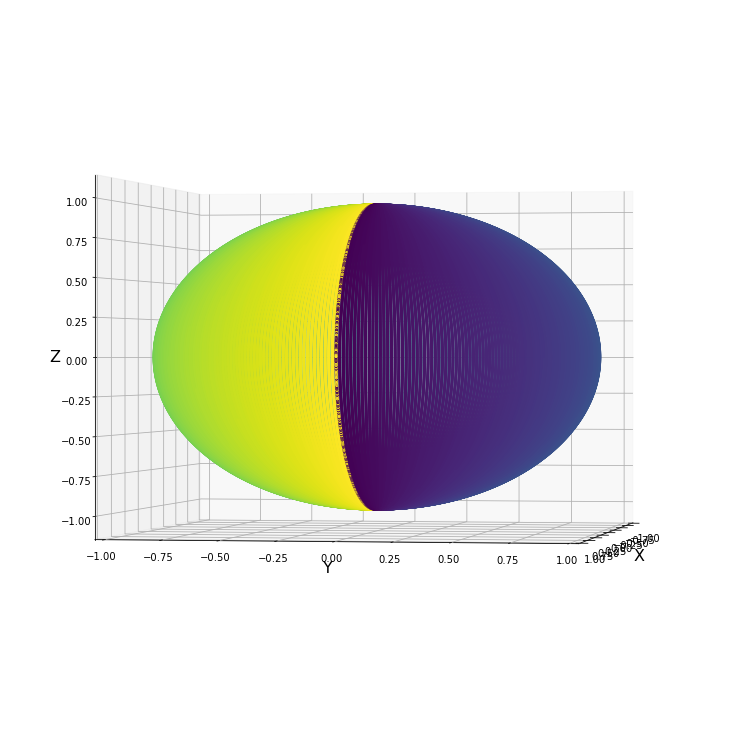

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
ax.view_init(elev=0, azim=10) # здесь можно повращать картинку, изменяя углы наклона


x, y, z = coords.T
сolors = np.linspace(0, 2*np.pi, len(x))
ax.scatter(x, y, z, marker="o", s=5, c=сolors)


ax.set_xlabel('X',size=16)
ax.set_ylabel('Y',size=16)
ax.set_zlabel('Z',size=16)

ax.set_xlim((-1,1))
ax.set_ylim((-1,1))

## интегрирование по шару

In [11]:
Cp_sphere = np.ones(coords.shape[0])*0
Cp_sphere[0:200] = 2

sint.get_CxCyCz_LabSys_byCp(coords, Cp_sphere, 1 ,sphere_zones, dims_zones_sphere, indeces_for_inver=[], Scalc=True)

(0.01236728637270974,
 9.737789204258146e-05,
 0.007873218360386494,
 12.534519787398063)

In [12]:
S_real = 4. * np.pi * Rad
S_real

12.566370614359172

площадь сходится. А отдельные проекции - не понятно

# Проверка интегратора на параллелепипеде

In [13]:
Na = 50
Nb = 50
Nc = 50
A, B, C = 2, 1, 1
x_set = np.linspace(-A, A, Na)
y_set = np.linspace(-B, B, Nb)
z_set = np.linspace(-C, C, Nc)

z_rect_1 = np.arange(0, Na*Nb)
z_rect_2 = np.arange(Na*Nb, Na*Nb*2)
z_rect_3 = np.arange(Na*Nb*2, Na*Nb*2 + Na*Nc)
z_rect_4 = np.arange(Na*Nb*2 + Na*Nc, Na*Nb*2 + Na*Nc*2)
z_rect_5 = np.arange(Na*Nb*2 + Na*Nc*2, Na*Nb*2 + Na*Nc*2 + Nb*Nc)
z_rect_6 = np.arange(Na*Nb*2 + Na*Nc*2 + Nb*Nc, Na*Nb*2 + Na*Nc*2 + 2*Nb*Nc)
rect_zones = [z_rect_1,z_rect_2,z_rect_3,z_rect_4,z_rect_5,z_rect_6]
dims_zones_rect = [(Na,Nb), (Na,Nb), (Na,Nc), (Na,Nc), (Nb,Nc), (Nb,Nc)]

In [14]:
coords = np.zeros((Na*Nb*2 + Na*Nc*2 + Nb*Nc*2, 3))

for i in range(Na):
    for j in range(Nb):
        coords[z_rect_1[i*Na + j]][0] = x_set[i]
        coords[z_rect_1[i*Na + j]][1] = y_set[j]
        coords[z_rect_1[i*Na + j]][2] = C

for i in range(Na):
    for j in range(Nb):
        coords[z_rect_2[i*Na + j]][0] = x_set[i]
        coords[z_rect_2[i*Na + j]][1] = y_set[j]
        coords[z_rect_2[i*Na + j]][2] = -C

for i in range(Na):
    for k in range(Nc):
        coords[z_rect_3[i*Na + k]][0] = x_set[i]
        coords[z_rect_3[i*Na + k]][1] = B
        coords[z_rect_3[i*Na + k]][2] = z_set[k]

for i in range(Na):
    for k in range(Nc):
        coords[z_rect_4[i*Na + k]][0] = x_set[i]
        coords[z_rect_4[i*Na + k]][1] = -B
        coords[z_rect_4[i*Na + k]][2] = z_set[k]
        
for j in range(Nb):
    for k in range(Nc):
        coords[z_rect_5[j*Nb + k]][0] = A
        coords[z_rect_5[j*Nb + k]][1] = y_set[j]
        coords[z_rect_5[j*Nb + k]][2] = z_set[k]
        
for j in range(Nb):
    for k in range(Nc):
        coords[z_rect_6[j*Nb + k]][0] = -A
        coords[z_rect_6[j*Nb + k]][1] = y_set[j]
        coords[z_rect_6[j*Nb + k]][2] = z_set[k]

Text(0.5, 0, 'Z')

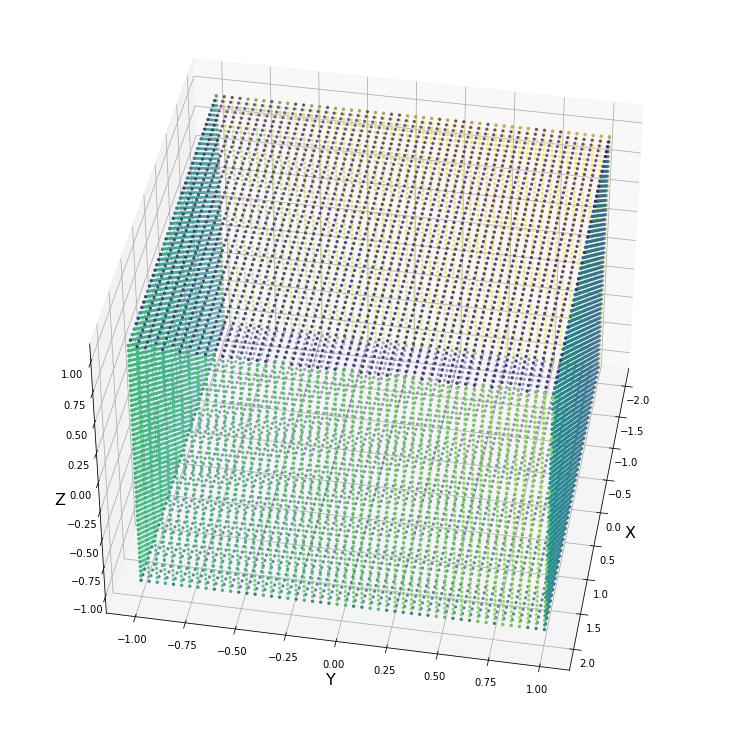

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
ax.view_init(elev=40, azim=10) # здесь можно повращать картинку, изменяя углы наклона


x, y, z = coords.T
сolors = np.linspace(0, 2*np.pi, len(x))
ax.scatter(x, y, z, marker="o", s=5, c=сolors)


ax.set_xlabel('X',size=16)
ax.set_ylabel('Y',size=16)
ax.set_zlabel('Z',size=16)

In [30]:
# поток бежит в сторону возрастающего Х. поток упирается в переднюю грань куба(то есть оринтация куба - по потоку)
# ось Y смотрит вверх

Cp_rect = np.ones(coords.shape[0])*0
Cp_rect[z_rect_1] = 0 # левая грань
Cp_rect[z_rect_2] = 0 # правая грань
Cp_rect[z_rect_3] = 0 # верхняя грань
Cp_rect[z_rect_4] = 0 # нижняя грань
Cp_rect[z_rect_5] = 0 # задняя грань
Cp_rect[z_rect_6] = 10# передняя грань
Cp_rect.shape

(15000,)

Посчитаем площадь

In [31]:
cx, cy, cz, s = sint.get_CxCyCz_LabSys_byCp(coords, Cp_rect, 1, rect_zones, dims_zones_rect, 
                                              indeces_for_inver=[1,2,5], Scalc=True)
s

40.000000000000966

In [32]:
# реальная площадь
2*2*2 + 2*4*2 + 4*2*2

40

In [33]:
cx, cy, cz

(40.00000000000101, 0.0, 0.0)

Результаты сходятся с теоретическими: $Cx = (S \cdot Cp)_{перед} - (S \cdot Cp)_{зад}$

In [36]:
sint.get_CxCyCz_SpdSys_byCp(coords, Cp_rect, 1, -45, rect_zones, dims_zones_rect, 
                                              indeces_for_inver=[1,2,5], Scalc=False)

(28.284271247462616, 28.284271247462613, 0.0)

In [35]:
40 / np.sqrt(2)

28.2842712474619

# Проверка интегратора на параллелепипеде с вырезанным дном (почти крыло)

In [26]:
A, Na = 1, 100
B, Nb = 1, 100
half_angle = 20

x_set = np.linspace(0, A*np.cos(half_angle/180. * np.pi), Na)
y_set = np.linspace(0, A*np.sin(half_angle/180. * np.pi), Na)
z_set = np.linspace(0, B, Nb)

z_rect_1 = np.arange(0, Na*Nb)
z_rect_2 = np.arange(Na*Nb, Na*Nb*2)
z_rect_3 = np.arange(Na*Nb*2, Na*Nb*3)
z_rect_4 = np.arange(Na*Nb*3, Na*Nb*4)

rect_zones = [z_rect_1,z_rect_2,z_rect_3,z_rect_4]
dims_zones_rect = [(Na,Nb), (Na,Nb),(Na,Nb), (Na,Nb)]

In [27]:
coords = np.zeros((Na*Nb*4, 3))

for i in range(Na):
    for j in range(Nb):
        coords[z_rect_1[i*Na + j]][0] = x_set[i]
        coords[z_rect_1[i*Na + j]][1] = -y_set[i]
        coords[z_rect_1[i*Na + j]][2] = z_set[j]

for i in range(Na):
    for j in range(Nb):
        coords[z_rect_2[i*Na + j]][0] = x_set[-1] + x_set[i]
        coords[z_rect_2[i*Na + j]][1] = -y_set[-1-i]
        coords[z_rect_2[i*Na + j]][2] = z_set[j]

for i in range(Na):
    for j in range(Nb):
        coords[z_rect_3[i*Na + j]][0] = x_set[i]
        coords[z_rect_3[i*Na + j]][1] = y_set[i]
        coords[z_rect_3[i*Na + j]][2] = z_set[-1-j]

for i in range(Na):
    for j in range(Nb):
        coords[z_rect_4[i*Na + j]][0] = x_set[-1] + x_set[i]
        coords[z_rect_4[i*Na + j]][1] = y_set[-1-i]
        coords[z_rect_4[i*Na + j]][2] = z_set[-1-j]

(-1.0, 1.0)

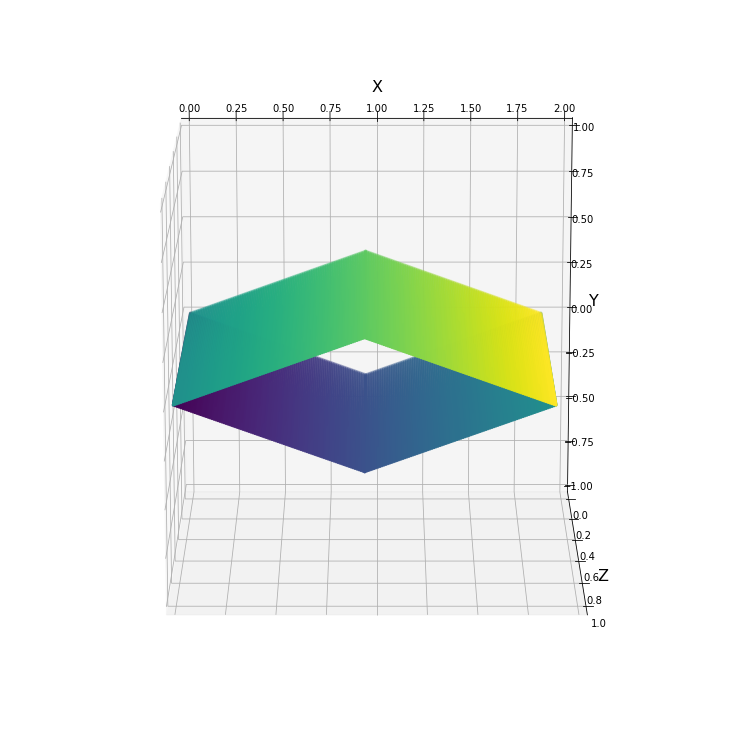

In [74]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
ax.view_init(elev=105, azim=-90) # здесь можно повращать картинку, изменяя углы наклона


x, y, z = coords.T
сolors = np.linspace(0, 2*np.pi, len(x))
ax.scatter(x, y, z, marker="o", s=5, c=сolors)


ax.set_xlabel('X',size=16)
ax.set_ylabel('Y',size=16)
ax.set_zlabel('Z',size=16)

ax.set_xlim((0,2))
ax.set_ylim((-1,1))
# ax.set_zlim((-1,1))

In [86]:
# нормали к граням
n1 = np.array([np.sin(half_angle/180*np.pi),
               np.cos(half_angle/180*np.pi), 
               0])
n2 = np.array([-np.sin(half_angle/180*np.pi),
               np.cos(half_angle/180*np.pi), 
               0])
n3 = np.array([np.sin(half_angle/180*np.pi),
               -np.cos(half_angle/180*np.pi), 
               0])
n4 = np.array([-np.sin(half_angle/180*np.pi),
               -np.cos(half_angle/180*np.pi), 
               0])

In [106]:
Cp_rect = np.ones(coords.shape[0])*0

Cp1,Cp2,Cp3,Cp4 = 1, -1 ,1 ,-1
Cp_rect[z_rect_1] = Cp1 # левая нижняя грань
Cp_rect[z_rect_2] = Cp2 # правая нижняя грань
Cp_rect[z_rect_3] = Cp3 # левая верхняя грань
Cp_rect[z_rect_4] = Cp4# правая верхняя грань

In [107]:
s_real = 4 * A * B
cx_real, cy_real, cz_real = Cp1*n1 + Cp2*n2 + Cp3*n3 + Cp4*n4

In [108]:
s, (cx, cy, cz) = CxCyCz_from_Cp_advanced(coords, Cp_rect, rect_zones, dims_zones_rect, indeces_for_inver=[])
print(f"calculated: \n s = {s}, \n cx = {cx}, \n cy = {cy}, \n cz = {cz}")
print(f"real values: \n s = {s_real}, \n cx = {cx_real}, \n cy = {cy_real}, \n cz = {cz_real}")

calculated: 
 s = 4.00000000000035, 
 cx = 1.3680805733026389, 
 cy = 0.0, 
 cz = 0.0
real values: 
 s = 4, 
 cx = 1.3680805733026749, 
 cy = 0.0, 
 cz = 0.0


# Вывод:
интегратор работает корректно. Для получения значений из папки `results` не хватает кого-то принципиально важного действия